In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
def plot_img(img):
    plt.figure(figsize=(10,7))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

In [3]:
part1_single_objects = "../COTSDataset/Part 1 - Single Objects"
part2_multiple_objects = "../COTSDataset/Part 2 - Multiple Objects"
part3_complex_background = "../COTSDataset/Part 3 - Complex Background"

In [4]:
img_path = os.path.join(part2_multiple_objects, "academic_book_no", "1_colour.jpeg")
# img_path = os.path.join(part2_multiple_objects, "academic_book_no", "2_colour.jpeg")
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

mask_path = os.path.join(part2_multiple_objects, "academic_book_no", "masks", "ac_3_colour_mask_7_mask.png")
# mask_path = os.path.join(part2_multiple_objects, "academic_book_no", "masks", "ac_3_colour_mask_8_mask.png")
mask = cv2.imread(mask_path)

In [5]:
# Extracting target bounding box from mask
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
mask = mask.astype(np.uint8)
# Find contours in the mask
contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Initialize an empty list to store bounding boxes
bounding_boxes = []

# Loop through the detected contours
for cnt in contours:
    # Get the bounding box for each contour
    x, y, w, h = cv2.boundingRect(cnt)
    
    # Add the bounding box coordinates to the list
    bounding_boxes.append((x, y, x + w, y + h))

# Find the minimum and maximum coordinates to create a bounding box around all masks
x1, y1 = min(box[0] for box in bounding_boxes), min(box[1] for box in bounding_boxes)
x2, y2 = max(box[2] for box in bounding_boxes), max(box[3] for box in bounding_boxes)

# Create the target bounding box that encompasses all masks
target_bbox = np.array([x1, y1, x2, y2])

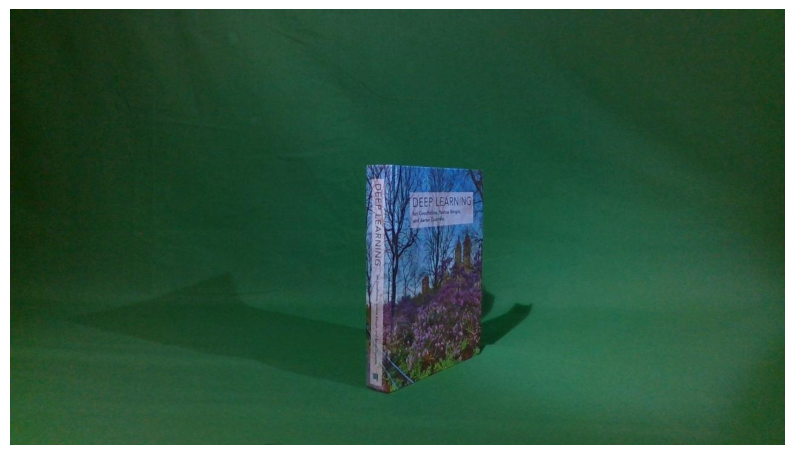

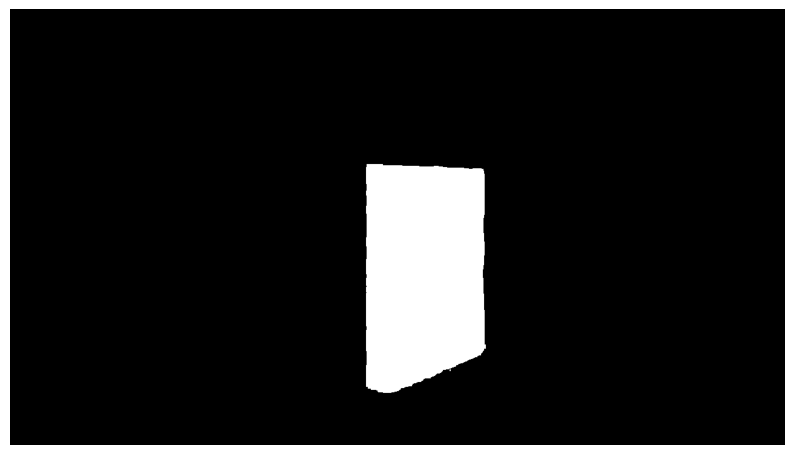

In [6]:
plot_img(img)
plot_img(mask)

In [7]:
from utils import *
from models import *
from env import *
from agent import DQNAgent

CUDA is available! Using GPU for computations.


In [8]:
# Creating the environment
env = DetectionEnv(img, img, target_bbox) #, feature_extractor=ResNet50FeatureExtractor(), target_size=RESNET50_TARGET_SIZE)

In [9]:
# env = DetectionEnv(img, img, target_bbox, feature_extractor=ResNet50FeatureExtractor(), target_size=RESNET50_TARGET_SIZE)

In [10]:
# env = DetectionEnv(img, img, target_bbox, feature_extractor=MobileNetV2FeatureExtractor(), target_size=MOBILENETV2_TARGET_SIZE)

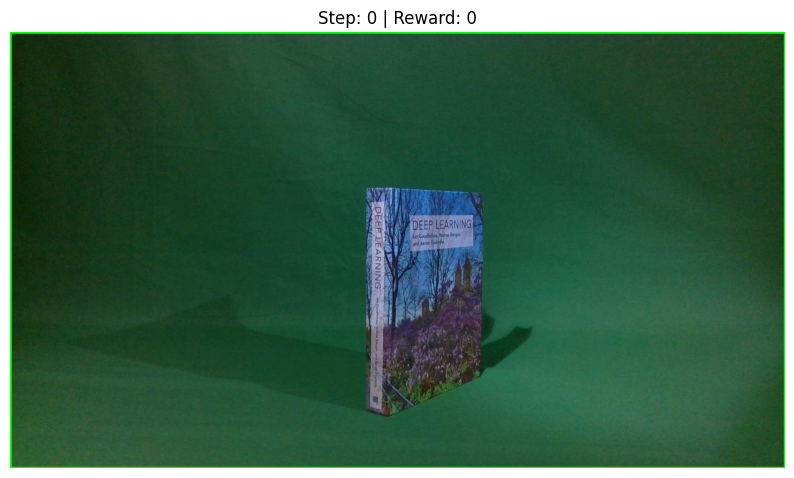

In [11]:
frame = env.render(do_display=True)

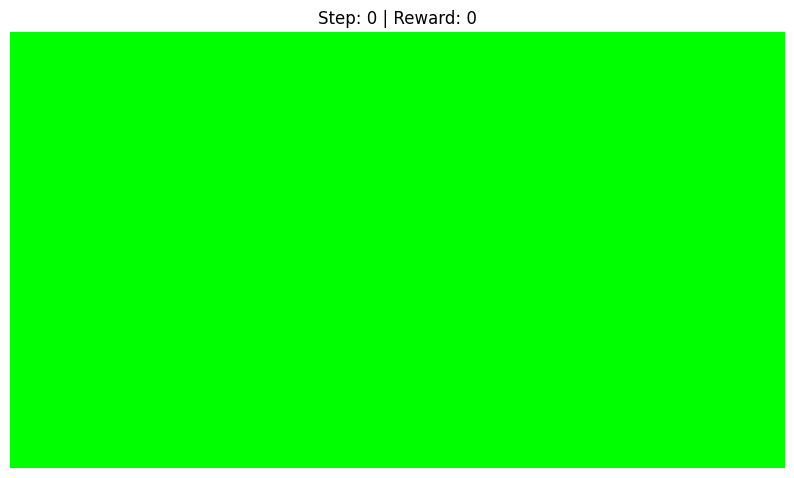

In [12]:
frame = env.render(do_display=True, mode='bbox')

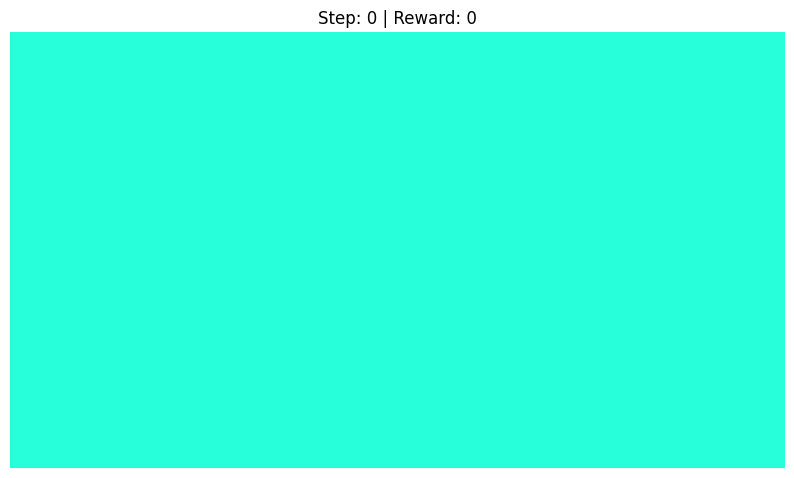

In [13]:
frame = env.render(do_display=True, mode='heatmap')

In [14]:
env.get_actions()

Actions:
0: Move right → 
1: Move left ←
2: Move up ↑
3: Move down ↓
4: Make bigger +
5: Make smaller -
6: Make fatter W
7: Make taller H
8: Trigger T


In [15]:
observation_space, info = env.reset()
print(observation_space)

Box(0.0, 100.0, (25268,), float32)


In [16]:
env.observation_space

Box(0.0, 100.0, (25268,), float32)

5
Terminated:  False
Truncated:  False
Reward:  1
IoU 0.4185956770004954
Recall 0.6443358136473459


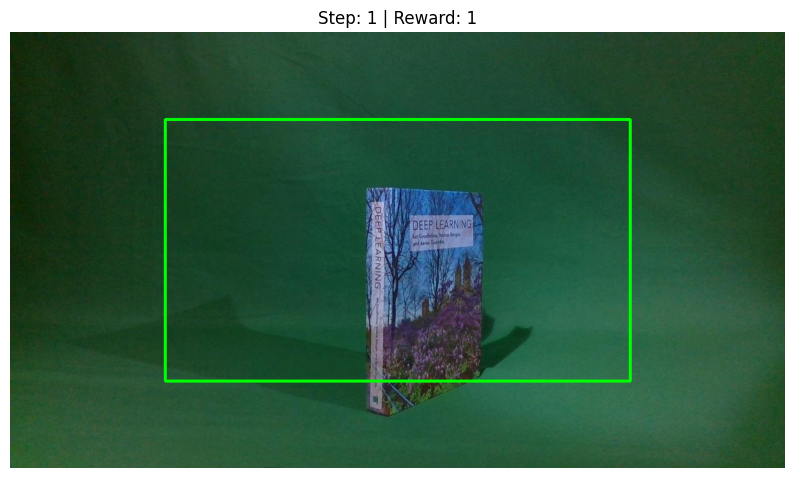

In [17]:
action = env.action_space.sample()

print(action)

# Taking a step in the environment
next_state, reward, terminated, truncated, info = env.step(action)
print("Terminated: ", terminated)
print("Truncated: ", truncated)
print("Reward: ", reward)
print("IoU", info['iou'])
print("Recall", info['recall'])
_ = env.render(do_display=True, mode='image')

In [18]:
img_path2 = os.path.join(part2_multiple_objects, "academic_book_no", "2_colour.jpeg")
# img_path = os.path.join(part2_multiple_objects, "academic_book_no", "2_colour.jpeg")
img2 = cv2.imread(img_path2)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

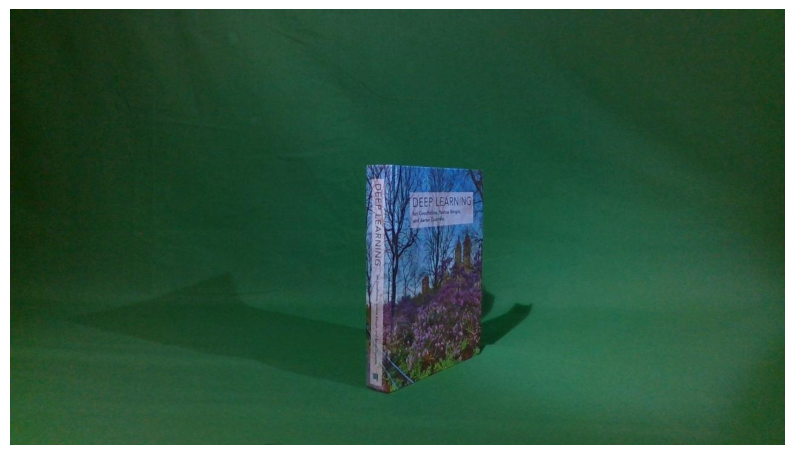

In [19]:
plot_img(img)

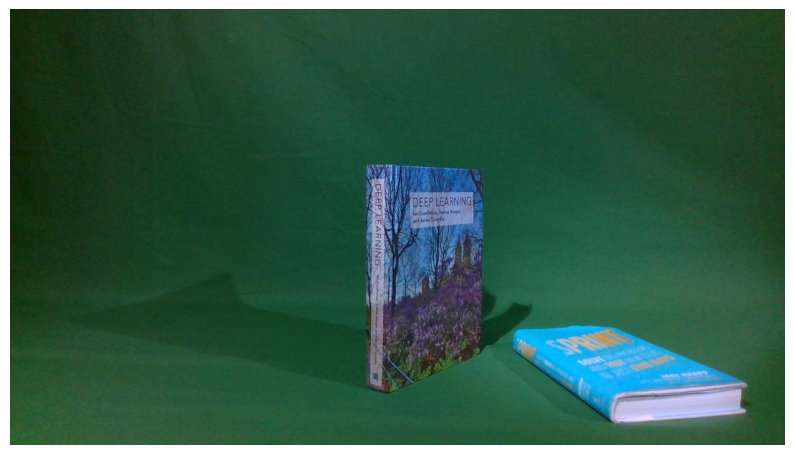

In [20]:
plot_img(img2)

In [21]:
def check(image1, image2):
    for i in range(len(image1)):
        for j in range(len(image1[0])):
            if image1[i][j] != image2[i][j]:
                print("Not equal")
                break

In [22]:
env.reset(image=img)
image1 = env.get_state()
env.reset(image=img2)
image2 = env.get_state()
check(image1, image2)

Not equal


In [23]:
env.reset(image=img2)
image1 = env.get_state()
env.reset(image=img2)
image2 = env.get_state()
check(image1, image2)

In [24]:
input_size = env.observation_space.shape[0]
output_size = env.action_space.n
save_path ="DQN_model1"
agent = DQNAgent(input_size, output_size, save_path=save_path)

In [25]:
# Training the agent
num_episodes = 100
rewards_list = []

for episode in range(num_episodes):
    env.reset()
    state = env.get_state()
    state = state.to(device)  # Move the state tensor to CUDA if available
    total_reward = 0
    agent.reset()
    
    print("Epsilon: ", agent.epsilon)

    while True:
        action = agent.select_action(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = truncated or terminated
        next_state = torch.Tensor(next_state).view(1, -1).to(device)  # Convert the next_state to a PyTorch tensor and move to CUDA if available
        total_reward += reward

        # Ensure all tensors used in replay buffer are on the CUDA device
        agent.replay_buffer.push(state.to(device), action, next_state.to(device), reward)

        state = next_state
        agent.update()

        if done:
            break

    rewards_list.append(total_reward)
    print(f"Episode {episode + 1}/{num_episodes}, Total Reward: {total_reward}")

Epsilon:  1.0
Episode 1/100, Total Reward: -4.0
Epsilon:  1.0
Episode 2/100, Total Reward: -1
Epsilon:  1.0
Episode 3/100, Total Reward: 1
Epsilon:  1.0
Episode 4/100, Total Reward: -1
Epsilon:  1.0
Episode 5/100, Total Reward: -1
Epsilon:  1.0
Episode 6/100, Total Reward: 1
Epsilon:  1.0
Episode 7/100, Total Reward: 1
Epsilon:  1.0
Episode 8/100, Total Reward: 1
Epsilon:  1.0
Episode 9/100, Total Reward: -1
Epsilon:  1.0
Episode 10/100, Total Reward: 1
Epsilon:  1.0
Episode 11/100, Total Reward: -1
Epsilon:  1.0
Episode 12/100, Total Reward: 1
Epsilon:  1.0
Episode 13/100, Total Reward: -1
Epsilon:  1.0
Episode 14/100, Total Reward: 1
Epsilon:  1.0
Episode 15/100, Total Reward: 1
Epsilon:  1.0
Episode 16/100, Total Reward: 1
Epsilon:  1.0
Episode 17/100, Total Reward: 1
Epsilon:  1.0
Episode 18/100, Total Reward: 1
Epsilon:  1.0
Episode 19/100, Total Reward: -1
Epsilon:  1.0
Episode 20/100, Total Reward: -3.0
Epsilon:  1.0
(tensor([[  0.,   0.,   0.,  ..., 100., 100., 100.]], device='

ValueError: only one element tensors can be converted to Python scalars